In [1]:
import joblib
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import allison
from allison.nn import Relu,Linear
from allison.nn import SGDMomentum
from allison.nn import Tensor,no_grad
from allison.nn import NeuralNetwork
from allison.nn import CrossEntropyLoss
from allison.metrics import confusion_matrix,classification_report
from allison.datasets import train_test_split

In [2]:
device = 'gpu' if allison.is_cuda_available() else 'cpu'
device

Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA runtime version: 13000
CuPy version: 13.6.0


'gpu'

# Datos

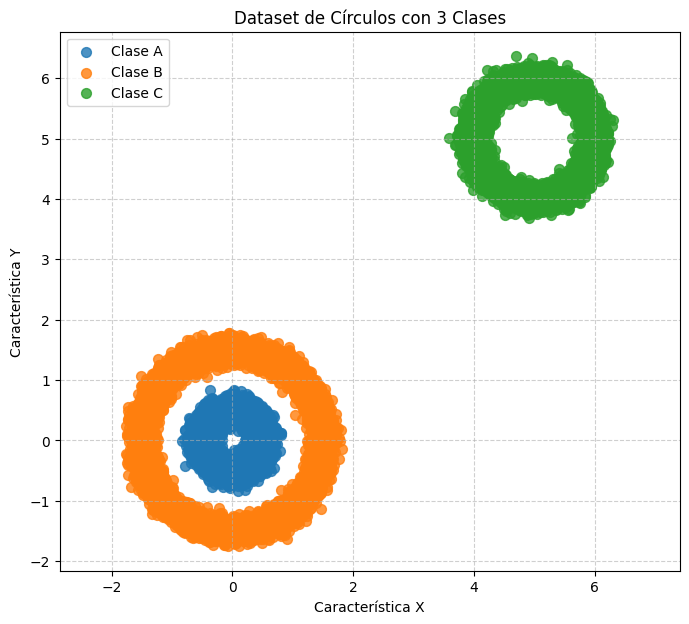

In [3]:
r1 = 0.5  
r2 = 1.5  
r3 = 1  

num_points = 10000
thetas = np.linspace(0, 2 * np.pi, num_points) 


x1 = r1 * np.cos(thetas) + 0.1 * np.random.randn(num_points)
y1 = r1 * np.sin(thetas) + 0.1 * np.random.randn(num_points)


x2 = r2 * np.cos(thetas) + 0.1 * np.random.randn(num_points)
y2 = r2 * np.sin(thetas) + 0.1 * np.random.randn(num_points)


x3 = 5 + r3 * np.cos(thetas) + 0.1 * np.random.randn(num_points)
y3 = 5 + r3 * np.sin(thetas) + 0.1 * np.random.randn(num_points)


plt.figure(figsize=(8, 7)) 


plt.scatter(x1, y1, s=50, label="Clase A", alpha=0.8) # Puntos de la Clase A
plt.scatter(x2, y2, s=50, label="Clase B", alpha=0.8) # Puntos de la Clase B
plt.scatter(x3, y3, s=50, label="Clase C", alpha=0.8) # Puntos de la Clase C

plt.xlabel("Característica X") 
plt.ylabel("Característica Y")
plt.title("Dataset de Círculos con 3 Clases")
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal')
plt.show() 


In [4]:
df = pd.DataFrame(
    {"x": x1.tolist()+x2.tolist()+x3.tolist(),
    "y": y1.tolist()+y2.tolist()+y3.tolist(),
    "labels":['A' for _ in range(num_points)]+['B' for _ in range(num_points)]+['C' for _ in range(num_points)]
    })

labels = df["labels"].unique()
labels2id = {label: i for i, label in enumerate(labels)}
id2labels = {v: k for k, v in labels2id.items()}

df["labels"] = df["labels"].map(labels2id)
df.head()

,x,y,labels
0,0.416955,-0.072717,0
1,0.606145,-0.011493,0
2,0.474810,0.003629,0
3,0.534443,-0.038671,0
4,0.572641,-0.072156,0


In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)



if device == 'gpu':
    X_train = Tensor(df_train[["x","y"]].values).to('gpu')
    Y_train = Tensor(df_train[["labels"]].values).to('gpu')

    X_test = Tensor(df_test[["x","y"]].values).to('gpu')
    Y_test = Tensor(df_test[["labels"]].values).to('gpu')

else:
    X_train = Tensor(df_train[["x","y"]].values)
    Y_train = Tensor(df_train[["labels"]].values)

    X_test = Tensor(df_test[["x","y"]].values)
    Y_test = Tensor(df_test[["labels"]].values)

print(f"X_train shape: {X_train.shape}, device: {X_train.device}")
print(f"Y_train shape: {Y_train.shape}, device: {Y_train.device}")
print(f"X_test shape: {X_test.shape}, device: {X_test.device}")
print(f"Y_test shape: {Y_test.shape}, device: {Y_test.device}")


X_train shape: (24000, 2), device: gpu
Y_train shape: (24000, 1), device: gpu
X_test shape: (6000, 2), device: gpu
Y_test shape: (6000, 1), device: gpu


In [6]:
X_train.grad

In [7]:
class Network(NeuralNetwork):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(2, 4)
        self.relu = Relu()
        self.fc2 = Linear(4, 4)
        self.fc3 = Linear(4, 3)

    def forward(self, x: Tensor) -> Tensor:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


net = Network().to(device)
net.parameters()

[Tensor(
 [[ 0.82184812  1.65849734 -0.21329843 -0.22710424]
  [-1.28396598  1.08825148 -0.06972136 -0.03704953]], shape=(2, 4), device=gpu, requires_grad=True),
 Tensor(
 [[0. 0. 0. 0.]], shape=(1, 4), device=gpu, requires_grad=True),
 Tensor(
 [[ 0.30648765  0.21343028 -0.09919398  0.93407362]
  [-1.13397806  0.14940732  0.28791216 -0.29160606]
  [ 0.43589576  0.46887451  0.78475726 -0.0788846 ]
  [-0.15354739  0.38126807 -0.13964173 -1.07575263]], shape=(4, 4), device=gpu, requires_grad=True),
 Tensor(
 [[0. 0. 0. 0.]], shape=(1, 4), device=gpu, requires_grad=True),
 Tensor(
 [[ 0.60982541 -1.29703549  0.28402848]
  [ 1.79498594  0.37703977 -0.49080712]
  [-0.31916267  0.26207058 -0.01511212]
  [ 0.53475129  1.02536398  0.9294297 ]], shape=(4, 3), device=gpu, requires_grad=True),
 Tensor(
 [[0. 0. 0.]], shape=(1, 3), device=gpu, requires_grad=True)]

In [8]:
criterion = CrossEntropyLoss()
optimizer = SGDMomentum(net.parameters(), learning_rate=1e-3, momentum=0.9)

In [9]:
out = net(X_train)
out

Tensor(
[[ 0.09700683  0.07251625 -0.0427447 ]
 [ 2.5896957   1.93589486 -1.14111312]
 [ 2.41427571  1.80476182 -1.06381676]
 ...
 [ 2.13852201  1.59862557 -0.94230975]
 [ 2.07840577  1.55368642 -0.91582037]
 [ 0.5179494   0.3016994  -0.09046196]], shape=(24000, 3), device=gpu, requires_grad=True)

# Training

In [10]:
# Bucle de entrenamiento mejorado
for epoch in range(10000 + 1):
    out = net(X_train)
    loss = criterion(Y_train, out)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        acc_train = (out.data.argmax(axis=1, keepdims=True) == Y_train.data).mean()
        with no_grad():
            out = net(X_test)
            acc_test = (out.data.argmax(axis=1, keepdims=True) == Y_test.data).mean()

        # Usamos una f-string para formatear y alinear la salida
        print(f"[{device}] Epoch {epoch:5d} | Loss: {loss.data:.4f} | Acc Train: {acc_train*100:.2f}% | Acc Test: {acc_test*100:.2f}%")

        if acc_test >= 0.95:  # Mejoramos el criterio de parada
            print(f"Entrenamiento completado en {epoch} epochs!")
            break


[gpu] Epoch     0 | Loss: 2.0359 | Acc Train: 33.64% | Acc Test: 31.90%
[gpu] Epoch   100 | Loss: 0.7176 | Acc Train: 57.97% | Acc Test: 58.88%
[gpu] Epoch   200 | Loss: 0.5965 | Acc Train: 76.29% | Acc Test: 76.52%
[gpu] Epoch   300 | Loss: 0.5261 | Acc Train: 80.17% | Acc Test: 81.02%
[gpu] Epoch   400 | Loss: 0.4855 | Acc Train: 83.42% | Acc Test: 84.05%
[gpu] Epoch   500 | Loss: 0.4571 | Acc Train: 83.47% | Acc Test: 84.35%
[gpu] Epoch   600 | Loss: 0.4350 | Acc Train: 83.79% | Acc Test: 84.78%
[gpu] Epoch   700 | Loss: 0.4156 | Acc Train: 84.74% | Acc Test: 85.68%
[gpu] Epoch   800 | Loss: 0.3978 | Acc Train: 85.70% | Acc Test: 86.55%
[gpu] Epoch   900 | Loss: 0.3816 | Acc Train: 86.65% | Acc Test: 87.25%
[gpu] Epoch  1000 | Loss: 0.3671 | Acc Train: 87.20% | Acc Test: 87.85%
[gpu] Epoch  1100 | Loss: 0.3534 | Acc Train: 87.64% | Acc Test: 88.13%
[gpu] Epoch  1200 | Loss: 0.3404 | Acc Train: 88.05% | Acc Test: 88.55%
[gpu] Epoch  1300 | Loss: 0.3278 | Acc Train: 88.35% | Acc Test:

# Prediction

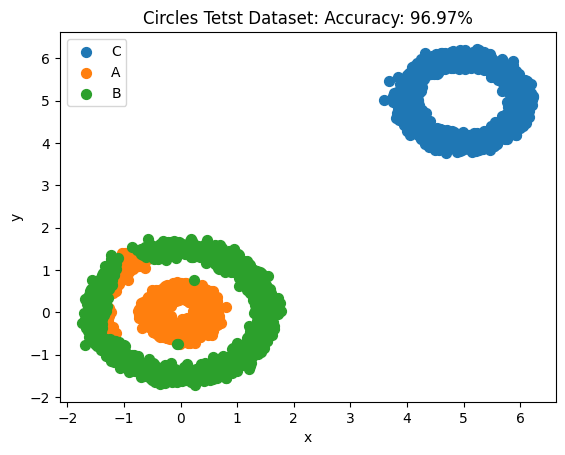

In [11]:
with no_grad():
    out = net(X_test)

y_pred = out.data.argmax(axis=1,keepdims=True)
acc = (y_pred == Y_test.data).mean()    

if device == "gpu":
    y_pred = y_pred.get().flatten()
else:
    y_pred = y_pred.flatten()

y_pred_labels = [id2labels[y] for y in y_pred]

df_test['pred_labels'] = y_pred_labels

for label in df_test['pred_labels'].unique():
    x = df_test[df_test['pred_labels'] == label]['x']
    y = df_test[df_test['pred_labels'] == label]['y']

    plt.scatter(x,y,s=50,label=label)

plt.title(f"Circles Tetst Dataset: Accuracy: {100*acc:.2f}%")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

<Axes: >

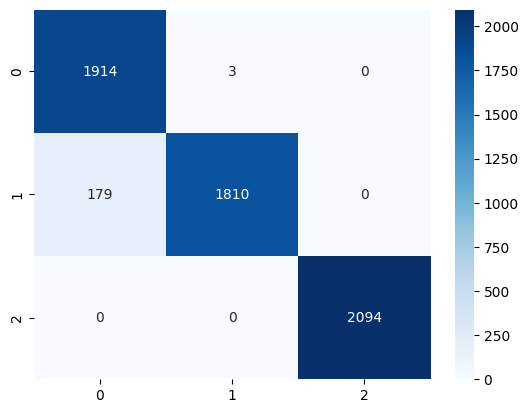

In [12]:
if device == "gpu":
    y_real = Y_test.data.flatten().get()
else:
    y_real = Y_test.data.flatten()

sns.heatmap(confusion_matrix(y_real, y_pred), annot=True, cmap="Blues", fmt=".0f")

In [13]:
print(classification_report(y_real, y_pred))

            precision   recall f1-score  support
0                0.91     1.00     0.95     1917
1                1.00     0.91     0.95     1989
2                1.00     1.00     1.00     2094

accuracy                           0.97     6000
macro avg        0.97     0.97     0.97     6000
weighted avg     0.97     0.97     0.97     6000


# Save and Load Model

In [14]:
import joblib

In [15]:
joblib.dump(net.weights(), "model_weights.joblib")

['model_weights.joblib']

# CPU

In [16]:
net2 = Network()
net2.load_weights(joblib.load('model_weights.joblib'))

if X_test.device == 'cpu':
    out = net2(X_test)
if X_test.device == 'gpu':
    out = net2(X_test.to('cpu'))

out

Tensor(
[[-26.00632785   9.76430051  15.5095612 ]
 [-26.2049647   10.16361907  15.78413906]
 [-23.87272916   8.45014088  14.03393052]
 ...
 [  4.83383693   2.95681042  -3.15630453]
 [  1.3845605    1.71804699  -1.48274147]
 [-28.02809146  10.94374922  16.98620328]], shape=(6000, 3), device=cpu, requires_grad=True)

# GPU

In [17]:
net2 = Network()
net2.load_weights(joblib.load('model_weights.joblib'))
net2.to('gpu')

if X_test.device == 'cpu':
    out = net2(X_test.to('gpu'))
if X_test.device == 'gpu':
    out = net2(X_test)

out

Tensor(
[[-26.00632785   9.76430051  15.5095612 ]
 [-26.2049647   10.16361907  15.78413906]
 [-23.87272916   8.45014088  14.03393052]
 ...
 [  4.83383693   2.95681042  -3.15630453]
 [  1.3845605    1.71804699  -1.48274147]
 [-28.02809146  10.94374922  16.98620328]], shape=(6000, 3), device=gpu, requires_grad=True)